In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

## Wrangle the webserver logs

In [3]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)

In [4]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [6]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [7]:
df = df.entry.apply(parse_log_entry)

In [8]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   request_path    13974 non-null  object
 4   http_version    13974 non-null  object
 5   status_code     13974 non-null  object
 6   size            13974 non-null  int64 
 7   user_agent      13974 non-null  object
dtypes: int64(1), object(7)
memory usage: 873.5+ KB


In [10]:
df['size_mb'] =df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)

In [11]:
df = df.set_index('timestamp')

In [12]:
# Count and Frequency to detect anomalies in discrete data
df.ip.value_counts().head()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
Name: ip, dtype: int64

In [13]:
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
Name: ip, dtype: float64

In [14]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [15]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
24.26.242.9,21,0.001503


<AxesSubplot:>

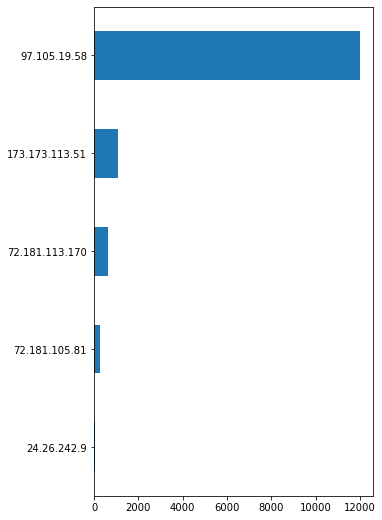

In [16]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5,9))

In [17]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [19]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


In [20]:
# For this part of the lesson it refers to some synthetic entries that were added (not added here)

In [21]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]


,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


## IP by user_agent

In [22]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [23]:
df.user_agent.value_counts()

python-requests/2.21.0                                                                                                       12001
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [24]:
df.http_version.value_counts()

HTTP/1.1    13974
Name: http_version, dtype: int64

In [26]:
user_df = pd.DataFrame(df.user_agent.value_counts(dropna=False)).reset_index().\
                    rename(columns={'index': 'user_agent', 'user_agent': 'count'})

In [27]:
user_df

,user_agent,count
0,python-requests/2.21.0,12001
1,python-requests/2.20.1,1911
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7
5,Slackbot 1.0 (+https://api.slack.com/robots),6
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2
8,Python-urllib/3.7,1


In [28]:
user_df2 = pd.DataFrame((df.user_agent.value_counts(dropna=False))/df.user_agent.count()).reset_index().\
                        rename(columns={'index': 'user_agent', 'user_agent': 'proba'})
user_df2.head()

,user_agent,proba
0,python-requests/2.21.0,0.858809
1,python-requests/2.20.1,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501


In [29]:
# merge them
user_df = user_df.merge(user_df2, on='user_agent')
user_df.head()

,user_agent,count,proba
0,python-requests/2.21.0,12001,0.858809
1,python-requests/2.20.1,1911,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501


<AxesSubplot:ylabel='user_agent'>

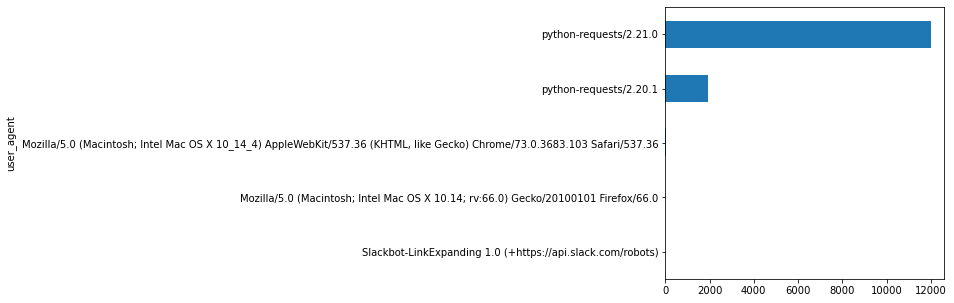

In [30]:
user_df.set_index('user_agent')['count'].sort_values().tail(5).plot.barh(figsize=(5,5))

<AxesSubplot:ylabel='user_agent'>

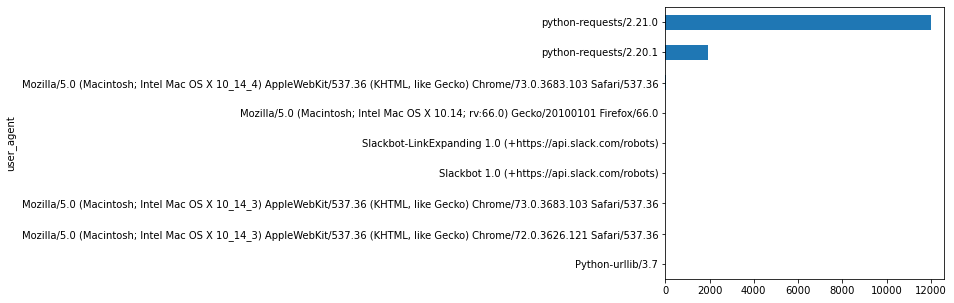

In [31]:
user_df.set_index('user_agent')['count'].sort_values().plot.barh(figsize=(5,5))

### Timestamp

In [32]:
df['month'] = df.index.strftime('%m-%b')
df['weekday'] = df.index.strftime('%A')

In [33]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,month,weekday
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,04-Apr,Tuesday
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,04-Apr,Tuesday
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,04-Apr,Tuesday
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,04-Apr,Tuesday
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,04-Apr,Tuesday


In [34]:
df.weekday.value_counts()

Tuesday      11947
Wednesday     2027
Name: weekday, dtype: int64

In [35]:
tue_df = df[df.weekday == 'Tuesday']
wed_df = df[df.weekday == 'Wednesday']

In [39]:
df.request_method.value_counts()

GET    13974
Name: request_method, dtype: int64

In [40]:
df.http_version.value_counts()

HTTP/1.1    13974
Name: http_version, dtype: int64

In [41]:
df.status_code.value_counts()

200    13958
499       16
Name: status_code, dtype: int64

In [44]:
tue_df.status_code.value_counts(), 14/11933

(200    11933
 499       14
 Name: status_code, dtype: int64,
 0.001173217128970083)

In [45]:
wed_df.status_code.value_counts(), 2/2025

(200    2025
 499       2
 Name: status_code, dtype: int64,
 0.0009876543209876543)

In [49]:
tue_df.request_path.value_counts()

/api/v1/sales?page=2       697
/api/v1/items              345
/api/v1/items?page=2       179
/api/v1/sales              135
/api/v1/items?page=3       121
                          ... 
/api/v1/items?page=0         1
/api/v1/stores?page=999      1
/api/v1/stores?page=2        1
/api/V1/HiZach!              1
/api/v1                      1
Name: request_path, Length: 216, dtype: int64

In [50]:
wed_df.request_path.value_counts()

/api/v1/items                        119
/api/v1/items?page=2                 112
/api/v1/items?page=3                  98
/api/v1/stores                        62
/api/v1/items?page=1                  18
                                    ... 
/favicon.ico                           3
/api/v1items                           1
/api/v1/items?page=4                   1
/api/v1/items/api/v1/items?page=2      1
/api/v1/items/api/v1/items?page=3      1
Name: request_path, Length: 197, dtype: int64

In [51]:
tue_df.month.value_counts()

04-Apr    11947
Name: month, dtype: int64

In [52]:
wed_df.month.value_counts()

04-Apr    2027
Name: month, dtype: int64

In [56]:
tue_df.describe()

,size,size_mb
count,11947.000000,11947.000000
mean,458732.670294,0.437482
std,149223.187363,0.142310
min,0.000000,0.000000
25%,501636.000000,0.478397
50%,510138.000000,0.486506
75%,511315.500000,0.487628
max,513736.000000,0.489937


In [57]:
wed_df.describe()

,size,size_mb
count,2027.000000,2027.000000
mean,397846.339418,0.379416
std,209125.472778,0.199438
min,0.000000,0.000000
25%,499783.000000,0.476630
50%,510130.000000,0.486498
75%,511164.000000,0.487484
max,513736.000000,0.489937


#### Could be further exploration but on the surface doesn't seem to be a big difference in interaction on tuesday or wednesday

In [58]:
df.index.min()

Timestamp('2019-04-16 19:34:42')

In [59]:
df.index.max()

Timestamp('2019-04-17 12:55:14')